In [5]:
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as ptl
from lightning.pytorch.callbacks import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import AUROC

In [6]:
mvtseries = pd.read_csv(
    "../assets/daily_multivariate_timeseries.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)

# mvtseries['Incoming Solar'].diff().plot()
mvtseries["target"] = (mvtseries["Incoming Solar"].diff() < -2000).astype(int)

In [7]:
class ExceedanceDataModule(ptl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, test_size: float = 0.2, batch_size: int = 1):
        super().__init__()

        self.data = data
        self.var_names = self.data.columns.tolist()
        self.batch_size = batch_size
        self.test_size = test_size

        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None

    def setup(self, stage=None):
        self.data["target"] = (self.data["Incoming Solar"].diff() < -2000).astype(int)

        self.data["time_index"] = np.arange(self.data.shape[0])
        self.data["group_id"] = 0

        unique_times = self.data["time_index"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(
            unique_times, test_size=self.test_size, shuffle=False
        )

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.1, shuffle=False)

        training_df = self.data.loc[self.data["time_index"].isin(tr_ind), :]
        validation_df = self.data.loc[self.data["time_index"].isin(vl_ind), :]
        test_df = self.data.loc[self.data["time_index"].isin(ts_ind), :]

        self.training = TimeSeriesDataSet(
            data=training_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=14,
            max_prediction_length=7,
            time_varying_unknown_reals=self.var_names,
            scalers={k: StandardScaler() for k in self.var_names if k != "target"},
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, self.data, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)


In [8]:

class ExceedanceLSTM(ptl.LightningModule):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, 1)

        self.test_predictions = []
        self.test_targets = []

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_dim).to(
            self.device
        )
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_dim).to(
            self.device
        )
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_bin = (y[0] > 0).any(axis=1).long().type(torch.FloatTensor)
        y_pred = self(x["encoder_cont"])

        loss = F.binary_cross_entropy(y_pred.squeeze(-1), y_bin)

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        y_bin = (y[0] > 0).any(axis=1).long().type(torch.FloatTensor)
        y_pred = self(x["encoder_cont"])

        loss = F.binary_cross_entropy(y_pred.squeeze(-1), y_bin)

        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_bin = (y[0] > 0).any(axis=1).long().type(torch.FloatTensor)
        y_pred = self(x["encoder_cont"])

        self.test_predictions.append(y_pred.detach().cpu())
        self.test_targets.append(y_bin.detach().cpu())

        loss = F.binary_cross_entropy(y_pred.squeeze(-1), y_bin)

        auroc = AUROC(task="binary")
        auc_score = auroc(y_pred, y_bin)

        self.log("test_bce", loss)
        self.log("test_auc", auc_score)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)



In [13]:

datamodule = ExceedanceDataModule(data=mvtseries, batch_size=64, test_size=0.3)

model = ExceedanceLSTM(input_dim=12, hidden_dim=32, num_layers=1)

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

trainer = ptl.Trainer(max_epochs=100, accelerator="cpu", callbacks=[early_stop_callback])

trainer.fit(model, datamodule)
trainer.test(model, datamodule)



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(

  | Name | Type   | Params | Mode  | FLOPs
------------------------------------------------
0 | lstm | LSTM   | 5.9 K  | train | 0    
1 | fc   | Linear | 33     | train | 0    
------------------------------------------------
5.9 K     Trainable params
0         Non-train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/volody/code/study-py/ts-pytorch/.venv/lib/pyt

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.5045038461685181
        test_bce            0.6947325468063354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


[{'test_bce': 0.6947325468063354, 'test_auc': 0.5045038461685181}]

In [14]:
# Aggregate test predictions and targets
test_preds = torch.cat(model.test_predictions).numpy()
test_targets = torch.cat(model.test_targets).numpy()

In [15]:

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_targets, test_preds)
roc_auc = auc(fpr, tpr)

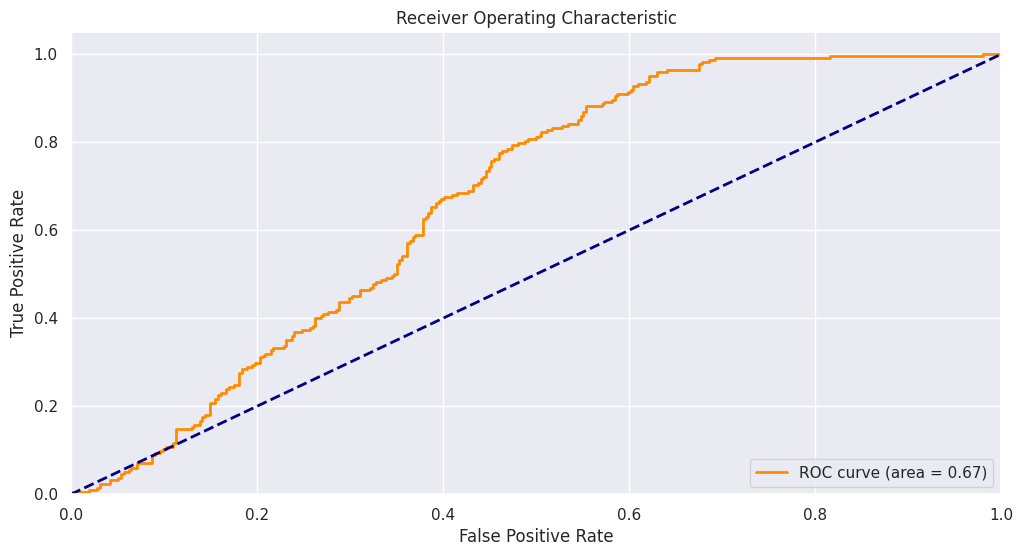

In [16]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()